# Just for fun. Style transfer of my cat photo

In [14]:
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL.Image
import time
import numpy as np
import tensorflow as tf
import IPython.display as display

In [12]:
class StyleContentModel(tf.keras.models.Model):
    """ Calss of style model initialization """
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = self.vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def vgg_layers(self, layer_names):
        """ Creates a vgg model that returns a list of intermediate output values."""
        # Load our model. Load pretrained VGG, trained on imagenet data
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in layer_names]
        model = tf.keras.Model([vgg.input], outputs)
        return model

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / (num_locations)


    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


def main(content_image_ini,
         style_image_ini,
         content_resize=(600, 400),
         style_resize=(400, 500),
        ):
    
    def reshape_and_normalize(img, size=(500, 500)):
        """ reshaper and normalizer of pictures """
        img = img.astype(np.float32) / 255.
        img = tf.image.resize(img, size=size)
        return tf.expand_dims(img, axis=0)


    def tensor_to_image(tensor):
        """ transform 4D tesor to 3D picture """
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return PIL.Image.fromarray(tensor)


    def clip_0_1(image):
        return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    
    content_image = reshape_and_normalize(content_image_ini, size=content_resize)
    style_image = reshape_and_normalize(style_image_ini, size=style_resize)

    content_layers = ['block5_conv4']

    style_layers = ['block1_conv1',
                    'block1_conv2',
                    'block2_conv1',
                    'block2_conv2',
                    'block3_conv1',
                    'block3_conv2',
                    'block3_conv3',
                    'block3_conv4',
                    'block4_conv1',
                    'block4_conv2',
                    'block4_conv3',
                    'block4_conv4',
                    'block5_conv1',
                    'block5_conv2',
                    'block5_conv3',
                    ]

    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    extractor = StyleContentModel(style_layers, content_layers)
    with tf.device(f'/GPU:0'):
        style_targets = extractor(style_image)['style']
        content_targets = extractor(content_image)['content']

    image = tf.Variable(content_image)

    def style_content_loss(outputs):
        """ Loss function where outputs came from StyleContentModel class"""
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                               for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                                 for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers
        loss = style_loss + content_loss
        return loss

    @tf.function()
    def train_step(image, opt, device='GPU'):
        """ training function with grad-tape """
        with tf.device(f'/{device}:0'):
            with tf.GradientTape() as tape:
                outputs = extractor(image)
                loss = style_content_loss(outputs)

            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))

    style_weight = 1e-2
    content_weight = 1e4

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    start = time.time()

    epochs = 10
    steps_per_epoch = 100

    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image, opt, 'GPU')
            print(".", end='', flush=True)
        display.clear_output(wait=True)
#         display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    
    plt.figure(figsize=(24, 8))
    plt.subplot(131)
    plt.imshow(tensor_to_image(content_image))
    plt.xticks([]), plt.yticks([])
    plt.subplot(132)
    plt.imshow(tensor_to_image(style_image))
    plt.xticks([]), plt.yticks([])
    plt.subplot(133)
    plt.imshow(tensor_to_image(image))
    plt.xticks([]), plt.yticks([])
    plt.show()

Train step: 1000
Total time: 267.9


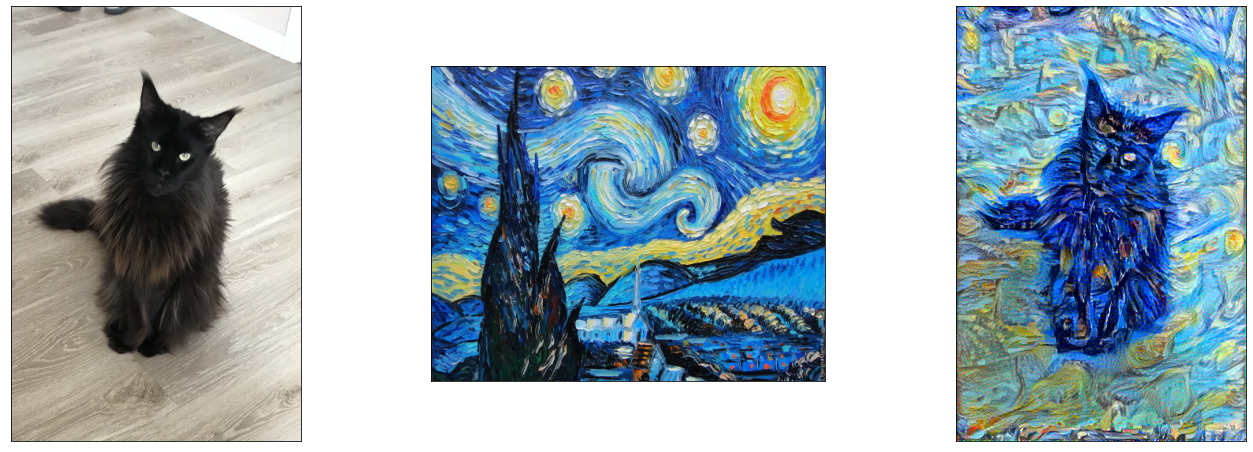

In [13]:
content_image_ini = imageio.v2.imread("Loki_2.jpg")
style_image_ini = imageio.v2.imread("style_3.jpeg")
main(content_image_ini, style_image_ini, content_resize=(600, 400), style_resize=(400, 500))

Train step: 1000
Total time: 269.2


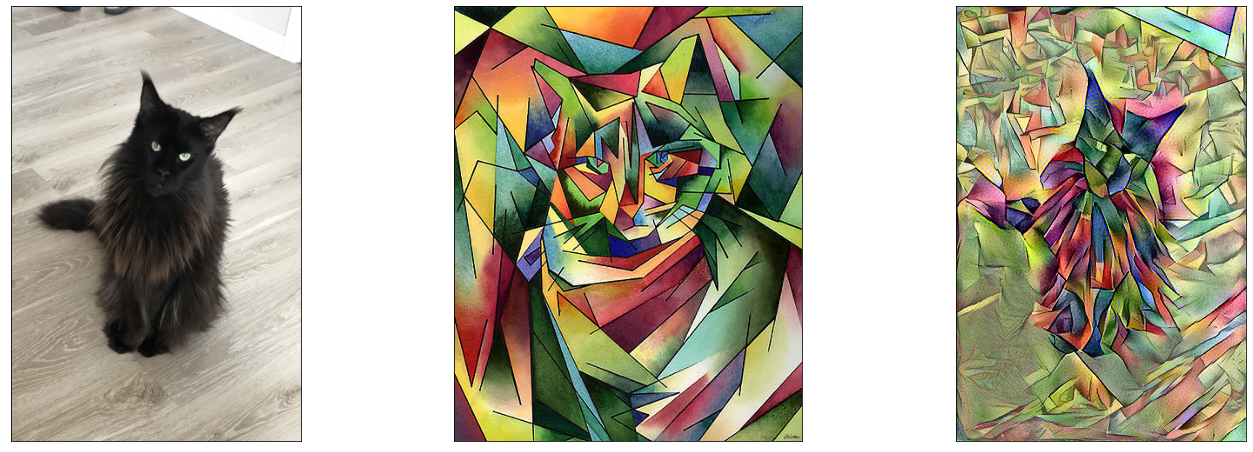

In [15]:
content_image_ini = imageio.v2.imread("Loki_2.jpg")
style_image_ini = imageio.v2.imread("style_2.jpeg")
main(content_image_ini, style_image_ini, content_resize=(600, 400), style_resize=(500, 400))